Something about ETS and tremor

In [1]:
# Load Python modules
import obspy
import obspy.clients.earthworm.client as earthworm
import obspy.clients.fdsn.client as fdsn
from obspy import read_inventory
from obspy import UTCDateTime
from obspy.core.stream import Stream
from obspy.signal.cross_correlation import correlate

import matplotlib.pyplot as plt
import numpy as np

from stacking import linstack, powstack, PWstack

%matplotlib inline

Something about the seismic arrays

In [2]:
# Define network, array, stations, and channels
network = 'XU'
arrayName = 'BS'
staCodes = 'BS01,BS02,BS03,BS04,BS05,BS06,BS11,BS20,BS21,BS22,BS23,BS24,BS25,BS26,BS27'
chans = 'SHE,SHN,SHZ'

In [3]:
# Define window time to download the data
myYear = 2010
myMonth = 8
myDay = 17
myHour = 6
TDUR = 2 * 3600.0
Tstart = UTCDateTime(year=myYear, month=myMonth, day=myDay, hour=myHour)
Tend = Tstart + TDUR

In [4]:
# Create a client server to download the data
fdsn_client = fdsn.Client('IRIS')

# or you can try:
# earthworm_client = earthworm.Client('rainier.ess.washington.edu', 16017)

In [5]:
# Download the data
Dtmp = fdsn_client.get_waveforms(network=network, station=staCodes, location='--', channel=chans, starttime=Tstart, \
    endtime=Tend, attach_response=True)

# or you can try:
# Dtmp = Stream()
# for ksta in range(0, len(staNames)):
#     for kchan in range(0, len(chaNames)):
#         trace = earthworm_client.get_waveforms(network=network, station=staNames[ksta], location='', \
#         channel=chaNames[kchan], starttime=Tstart, endtime=Tend)
#         if len(trace) > 0:
#             Dtmp.append(trace[0])

In [6]:
# Remove the stations that have a different amount of data
ntmp = []
for ksta in range(0, len(Dtmp)):
    ntmp.append(len(Dtmp[ksta]))
ntmp = max(set(ntmp), key=ntmp.count)
D = Dtmp.select(npts=ntmp)

Let us now have a look at the data

In [7]:
def plot_2hour(D, channel, offset, title):
    """ Plot seismograms
        D = Stream
        channel = 'E', 'N', or 'Z'
        offset = Offset between two stations
        title = Title of the figure
    """
    fig, ax = plt.subplots(figsize=(15, 10))
    Dplot = D.select(component=channel)
    t = (1.0 / Dplot[0].stats.sampling_rate) * np.arange(0, Dplot[0].stats.npts)
    for ksta in range(0, len(Dplot)):
        plt.plot(t, ksta * offset + Dplot[ksta].data, 'k')
    plt.xlim(np.min(t), np.max(t))
    plt.ylim(- offset, len(Dplot) * offset)
    plt.title(title, fontsize=24)
    plt.xlabel('Time (s)', fontsize=24)
    ax.set_yticklabels([])
    ax.tick_params(labelsize=20)

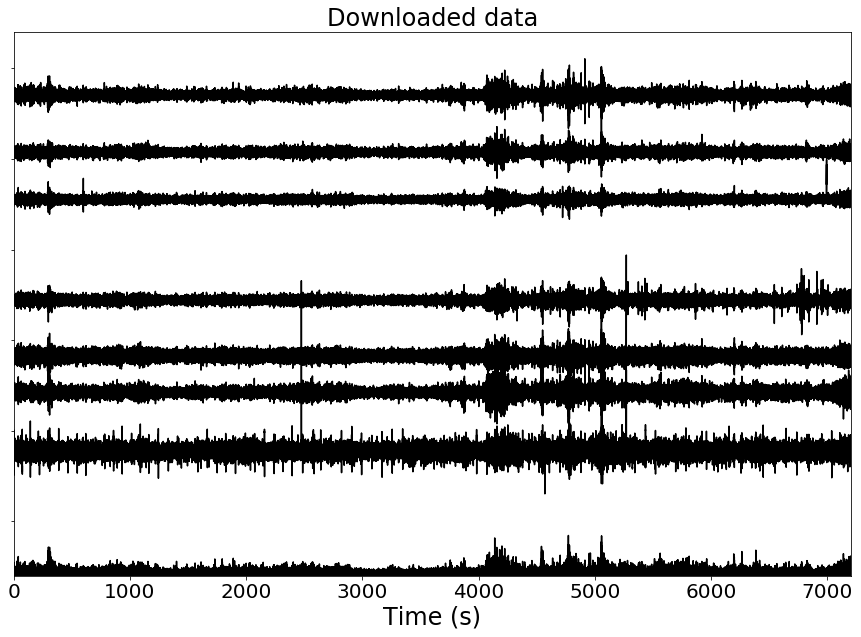

In [8]:
plot_2hour(D, 'E', 1200.0, 'Downloaded data')

Now we need to detrend the data

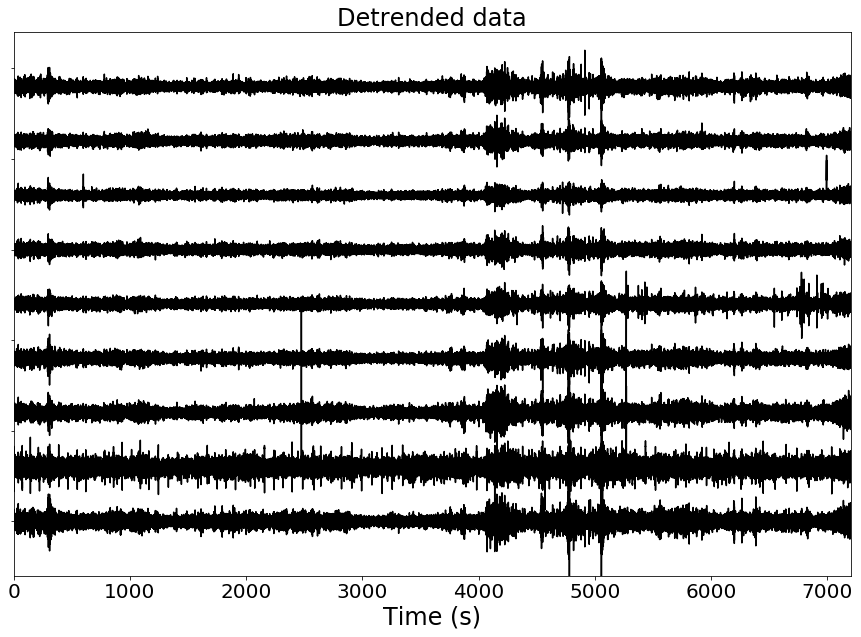

In [9]:
D.detrend(type='linear')
plot_2hour(D, 'E', 1200.0, 'Detrended data')

We taper the first and last five seconds of data

/anaconda3/envs/seismic/lib/python3.6/site-packages/obspy/core/trace.py:2111: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


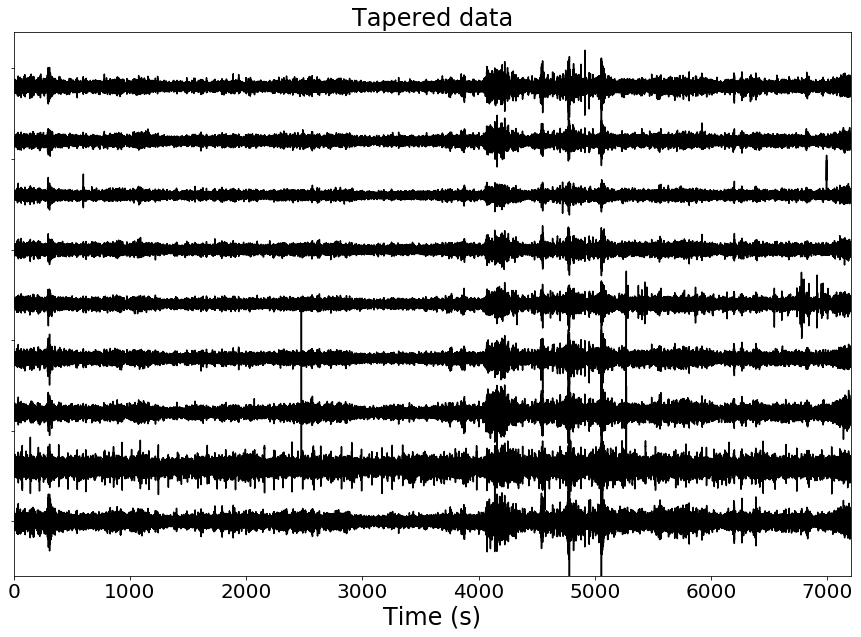

In [10]:
D.taper(type='hann', max_percentage=None, max_length=5.0)
plot_2hour(D, 'E', 1200.0, 'Tapered data')

We remove the instrument response

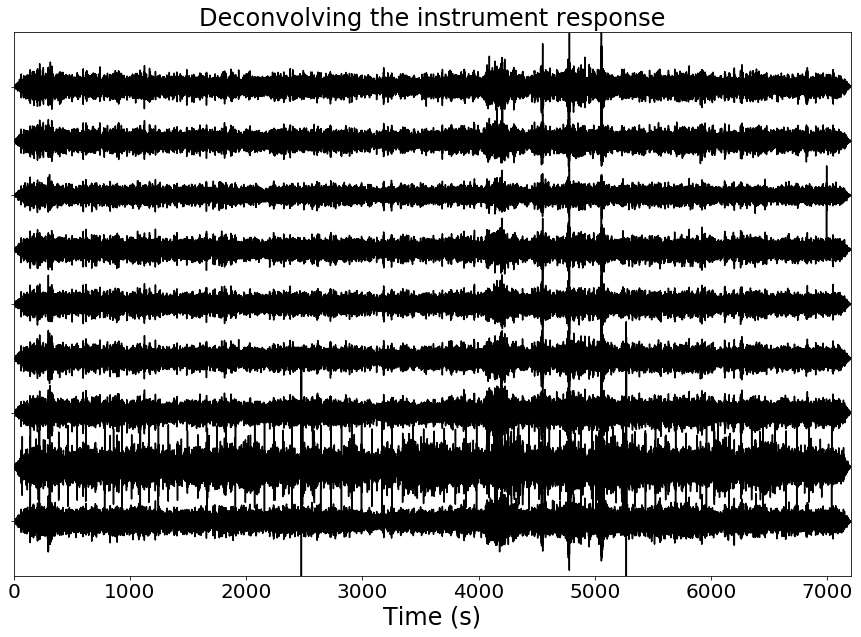

In [11]:
D.remove_response(output='VEL', pre_filt=(0.2, 0.5, 10.0, 15.0), water_level=80.0)
plot_2hour(D, 'E', 1.0e-6, 'Deconvolving the instrument response')

We filter the data

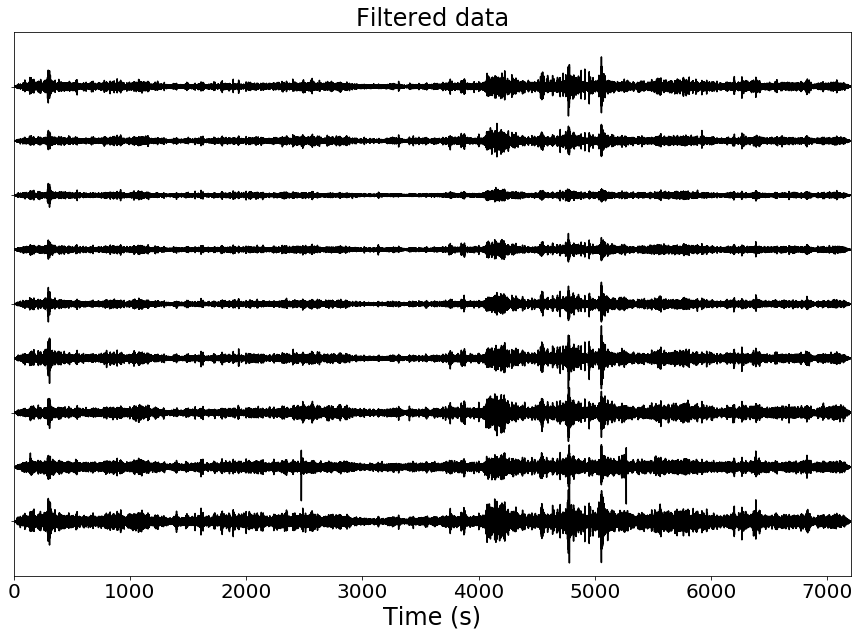

In [12]:
D.filter('bandpass', freqmin=2.0, freqmax=8.0, zerophase=True)
plot_2hour(D, 'E', 1.0e-6, 'Filtered data')

And we resample the data from 0.02 s (50 Hz) to 0.05 s (20 Hz)

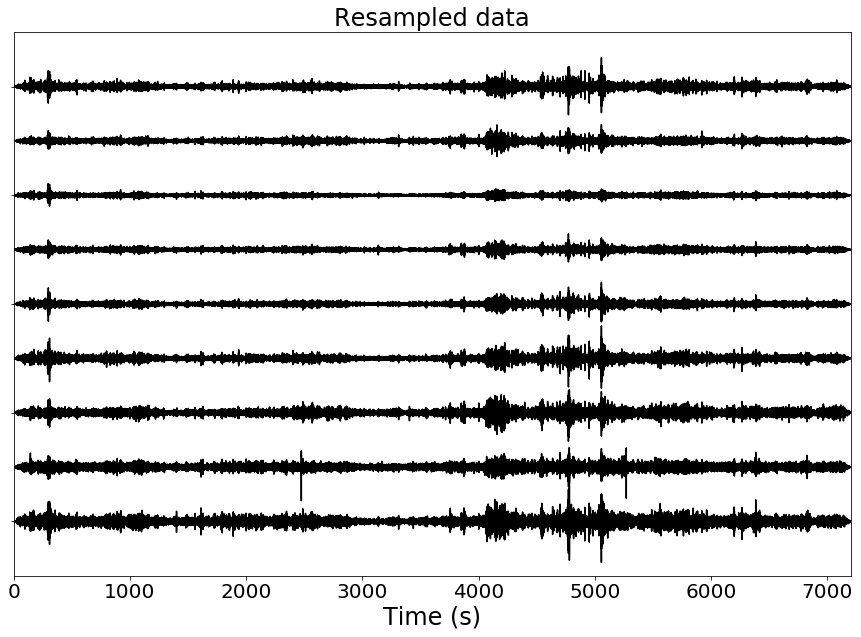

In [13]:
D.interpolate(100.0, method='lanczos', a=10)
D.decimate(5, no_filter=True)
plot_2hour(D, 'E', 1.0e-6, 'Resampled data')

In [16]:
tdur = 30.0
ncor = 400
EW = D.select(component='E').slice(Tstart + 60 * tdur, Tstart + 61 * tdur)
UD = D.select(component='Z').slice(Tstart + 60 * tdur, Tstart + 61 * tdur)
cc = np.zeros((2 * ncor + 1, len(EW)))
for ksta in range(0, len(EW)):
    cc[:, ksta] = correlate( EW[ksta], UD[ksta], ncor)